In [1]:
import pandas as pd
import numpy as np
from scipy.ndimage import gaussian_filter, convolve

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# Tests with a fixed kernel

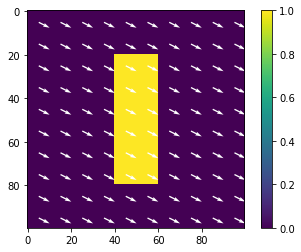

In [2]:
u,v=2,-1
N=100

orig = np.zeros((N,N))
orig[N//5:4*N//5,4*N//10:6*N//10]=1

nskip=N//10
skip=(slice(nskip//2,None,nskip),slice(nskip//2,None,nskip))
X,Y = np.meshgrid(np.arange(N),np.arange(N))
U = 2*np.ones((N,N))
#U[:N//2,:]=-1
V = -np.ones((N,N))

plt.imshow(orig)
plt.quiver(X[skip],Y[skip],U[skip],V[skip],color="w")
plt.colorbar()

Text(0.5, 1.0, 'anisotropic gauss kernel 2')

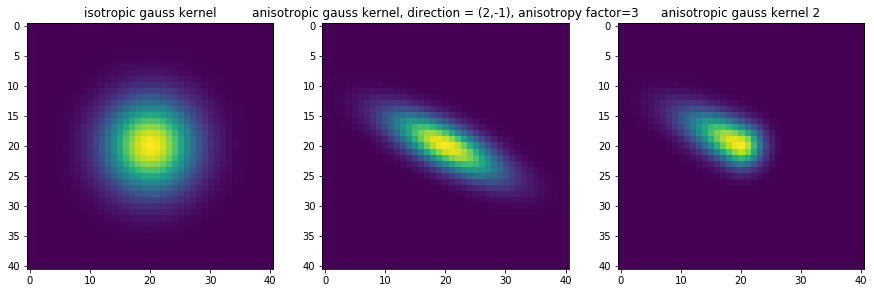

In [3]:
sigma = 5
kernel_size=4*sigma
X_kernel,Y_kernel = np.meshgrid(np.arange(-kernel_size,kernel_size+1),np.arange(-kernel_size,kernel_size+1))

def gaussian_isotropic(x,y,sigma):
    return np.exp(-1/(2*sigma**2)*(x**2+y**2))

def gaussian(x,y,invcov):
    return np.exp(-1/2 * (invcov[0,0]*x**2 + (invcov[1,0]+invcov[0,1])*x*y + invcov[1,1]*y**2))

def u_invcov(u,v,alpha,sigma):
    sigma1 = sigma*np.sqrt(2/(1+alpha**2))#scaled std so that total variance = sigma**2
    rotation_matrix = 1/np.sqrt(u**2+v**2) * np.array([[u,v],
                                                [-v,u]])
    diag_matrix = np.diag([1/(alpha*sigma1)**2,1/sigma1**2])
    return np.dot(np.dot(rotation_matrix,diag_matrix),np.transpose(rotation_matrix))
    

gauss_kernel_iso = gaussian_isotropic(X_kernel,Y_kernel,sigma)
gauss_kernel_iso/=np.sum(gauss_kernel_iso)

alpha=3
#sigma /= np.sqrt(2/(1+alpha**2))
#kernel_size=4*alpha*sigma
#X_kernel,Y_kernel = np.meshgrid(np.arange(-kernel_size,kernel_size+1),np.arange(-kernel_size,kernel_size+1))
invcov = u_invcov(u,v,alpha,sigma)
gauss_kernel_aniso_ns = gaussian(X_kernel,Y_kernel,invcov)
gauss_kernel_aniso = gauss_kernel_aniso_ns/np.sum(gauss_kernel_aniso_ns)


gauss_kernel_iso2 = gaussian_isotropic(X_kernel,Y_kernel,sigma*np.sqrt(2/(1+alpha**2)))
gauss_kernel_aniso2 = gauss_kernel_aniso_ns*(u*X_kernel-v*Y_kernel<=0)+gauss_kernel_iso2*(u*X_kernel-v*Y_kernel>0)
gauss_kernel_aniso2/=np.sum(gauss_kernel_aniso2)

fig,(ax1,ax2,ax3)=plt.subplots(1,3,figsize=(15,5))

ax1.imshow(gauss_kernel_iso)
ax1.set_title("isotropic gauss kernel")

ax2.imshow(gauss_kernel_aniso)
ax2.set_title("anisotropic gauss kernel, direction = (2,-1), anisotropy factor=%i"%alpha)

ax3.imshow(gauss_kernel_aniso2)
ax3.set_title("anisotropic gauss kernel 2")


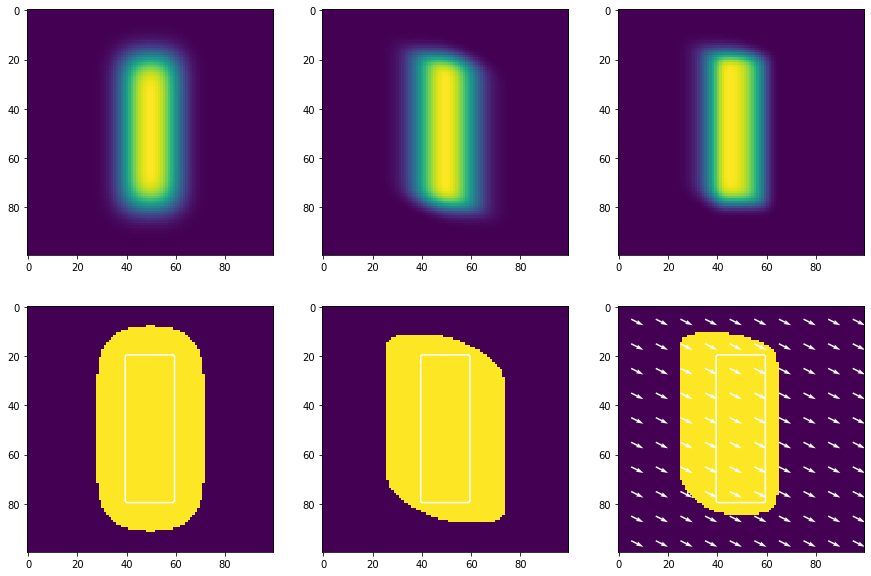

In [4]:
fig,ax=plt.subplots(2,3,figsize=(15,10))

orig_gauss = convolve(orig,gauss_kernel_iso)  
orig_gauss2 = convolve(orig,gauss_kernel_aniso)
orig_gauss3 = convolve(orig,gauss_kernel_aniso2)

ax[0][0].imshow(orig_gauss )
ax[0][1].imshow(orig_gauss2)
ax[0][2].imshow(orig_gauss3)

ax[1][0].imshow(1*(orig_gauss >0.01))
ax[1][1].imshow(1*(orig_gauss2>0.01))
ax[1][2].imshow(1*(orig_gauss3>0.01))

kw = {'levels':[0.5], 'colors':['w']}
ax[1][0].contour(orig,**kw)
ax[1][1].contour(orig,**kw)
ax[1][2].contour(orig,**kw)

plt.quiver(X[skip],Y[skip],U[skip],V[skip],color="w")

# Tests with a space-varying kernel

In [5]:
def convolveCustom(f,g,mode='wrap'):
    """2D convolution with a space-varying kernel g
        g must have shape (f.shape[0],f.shape[1],ng,mg) where (ng,mg) is the kernel shape at each point"""
    rep=np.zeros(f.shape)
    ng,mg = g.shape[2:4]
    fpad = np.pad(f,(ng,mg),mode=mode)
    for i in range(f.shape[0]):
        for j in range(f.shape[1]):
            rep[i,j] = np.sum(g[i,j][::-1,::-1]*fpad[ng+i- ng//2 : 2*ng+i- ng//2,mg+j- mg//2 : 2*mg+j- mg//2])
            
    return rep


def spaceVaryingAnisotropicKernel(U,V,sigma):
    """Return a space-varying kernel (of shape (f.shape[0],f.shape[1],ng,ng))
    where ng=4*int(sigma) is the kernel size at each point
    The kernel is basically consituted of two parts :
     - an upstream part, which is an anisotropic gaussian kernel with total variance sigma**2,
       and a std that is alpha times bigger along the vector (U[i,j],V[i,j]) than along its orthogonal direction
       where alpha depends on the vector norm
     - a downstream part that is an isotropic gaussian kernel with total variance sigma'**2 
     (sigma' chosen to match upstream kernel shape)
    """
    assert U.shape==V.shape
    kernel_size=2*int(np.ceil(sigma))
    rep = np.zeros((U.shape[0],U.shape[1],2*kernel_size+1,2*kernel_size+1))
    X_kernel,Y_kernel = np.meshgrid(np.arange(-kernel_size,kernel_size+1),np.arange(-kernel_size,kernel_size+1))

    for i in range(U.shape[0]):
        for j in range(U.shape[1]):    
            # compute the upstream half of the kernel
            u,v = U[i,j],V[i,j]
            alpha = 1+np.sqrt((u**2+v**2))
            invcov = u_invcov(u,v,alpha,sigma) #inverse covariance matrix on the upstream half of the kernel
            gauss_kernel_aniso = gaussian(X_kernel,Y_kernel,invcov)
            
            #compute the downstream half of the kernel; sigma is modified to accound for the distortion of the upstream kernel
            gauss_kernel_iso = gaussian_isotropic(X_kernel,Y_kernel,sigma*np.sqrt(2/(1+alpha**2)))
            
            #final kernel is split between upstream anisotropic part and downstream isotropic part
            gauss_kernel_final = gauss_kernel_aniso*(u*X_kernel-v*Y_kernel<=0)+gauss_kernel_iso*(u*X_kernel-v*Y_kernel>0)
            rep[i,j] = gauss_kernel_final/np.sum(gauss_kernel_final)
            
    return rep

    

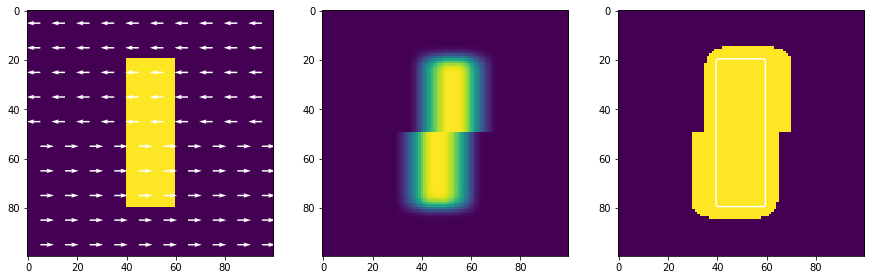

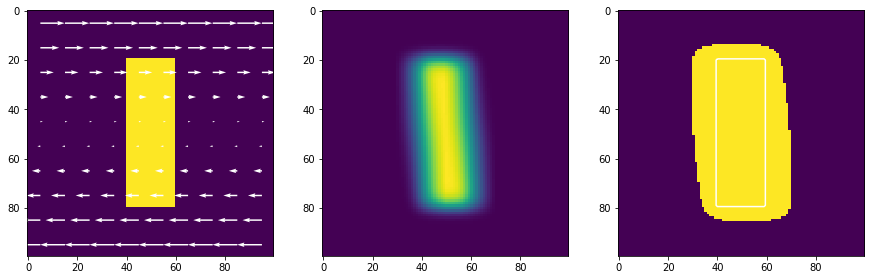

In [6]:
U = 2*np.ones((N,N))
U[:N//2,:]=-U[:N//2,:]
V = np.zeros((N,N))
X,Y = np.meshgrid(np.arange(N),np.arange(N))

kernel = spaceVaryingAnisotropicKernel(U,V,5)
finalConvolve = convolveCustom(orig,kernel)

fig,ax=plt.subplots(1,3,figsize=(15,5))

ax[0].imshow(orig)
ax[0].quiver(X[skip],Y[skip],U[skip],V[skip],color="w")
ax[1].imshow(finalConvolve)
ax[2].imshow(1.*(finalConvolve>0.01))
kw = {'levels':[0.5], 'colors':['w']}
ax[2].contour(orig,**kw)



U = 2*np.ones((N,N))*np.linspace(1,-1,N).reshape((N,1))
V = np.zeros((N,N))

kernel = spaceVaryingAnisotropicKernel(U,V,5)
finalConvolve = convolveCustom(orig,kernel)

fig,ax=plt.subplots(1,3,figsize=(15,5))

ax[0].imshow(orig)
ax[0].quiver(X[skip],Y[skip],U[skip],V[skip],color="w")
ax[1].imshow(finalConvolve)
ax[2].imshow(1.*(finalConvolve>0.01))
ax[2].contour(orig,**kw)

# Tests on real-world geometry

In [7]:
import cartopy.crs as ccrs
import cartopy

import xarray as xr
import glob
import time
from xarray.ufuncs import cos, deg2rad

In [8]:
CMIP6_FOLDER = "/global/cfs/projectdirs/m3522/cmip6/"
def mean_era5(year1,year2,varid,mnth=""):
    """Compute the monthly climatology of a 3D or 4D ERA5 variable for years between year1 and year2 (included),
    year1/2 must be of the type "yyyy"
    varid gives the id of the variable in era5, e.g. '128_135_w' for omega
    mnth is an str that gives the month to be considered
    """
    path = "/global/homes/w/wboos/m3310project/wboos/era5monthlyQuentin/"
    
    era5varsum = 0
    count = int(year2)+1-int(year1)
    era5varlist = []
    for y in [str(year) for year in range(int(year1),int(year2)+1)]:
        era5var = xr.open_dataset(glob.glob(path+"*/e5.*.%s.*.%s*.nc"%(varid,y))[0])
        varname = list(era5var.data_vars)[0] #get name of the main variable, eg 'W' for omega
        if len(mnth)>0:
            era5var1 = era5var[varname].sel(time=pd.to_datetime(y+mnth,format='%Y%m'))
        else :
            era5var1 = era5var[varname].mean("time")
        era5varsum += era5var1
        era5varlist.append(era5var1)
    #climatology = xr.concat(era5varlist,"time").groupby("time.month").mean("time")
    return era5varsum/count#climatology#

def spatial_mean(ds):
    """Compute spatial mean of a Dataset"""
    coslat = cos(deg2rad(ds.latitude))
    weight_factor = coslat / coslat.mean('latitude')
    return (ds*weight_factor).mean(['latitude','longitude'])

def spatial_integ(ds):
    """Compute spatial integral of a Dataset"""
    coslat = cos(deg2rad(ds.latitude))
    return (6370e3)**2*(ds*coslat).sum(['latitude','longitude'])

def precip_pct(mask,precipmap,globmask=0):
    mask2 = mask.interp_like(precipmap)
    if type(globmask)==int and globmask==0 :
        globmask2=1
    else :
        globmask2 = globmask.interp_like(precipmap)
    return 100*np.array(spatial_mean(mask2*globmask2*precipmap))/np.array(spatial_mean(globmask2*precipmap))


orog1 = xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc")
orog=orog1.Z.isel(time=0)/9.80665

m_per_degreelat = 6370*1e3*np.pi/180

coslat = np.cos(orog.latitude*np.pi/180.)
coslat += 1e-5*(1-1*(coslat>1e-5))

ddxorog = orog.differentiate("longitude")/(m_per_degreelat*coslat)
ddyorog = orog.differentiate("latitude")/m_per_degreelat

In [373]:
pr_trmm=xr.open_dataset("/global/cscratch1/sd/wboos/data/trmm/pr_TRMM-L3_v7-7A_199801-201312.nc").pr*3600*24
pr_trmm_mean07 = pr_trmm.sel(time=(pr_trmm['time.month']==7)).mean('time').rename({'lat': 'latitude','lon': 'longitude'})

pw_era5_mean07 = mean_era5("2010","2013",'128_137_tcwv',mnth="07")

u100m_era5_mean07 = mean_era5("2010","2013",'228_246_100u',mnth="07")
v100m_era5_mean07 = mean_era5("2010","2013",'228_247_100v',mnth="07")

upslope_w_era5_07 = (u100m_era5_mean07*ddxorog.interp_like(u100m_era5_mean07)+
                  v100m_era5_mean07*ddyorog.interp_like(u100m_era5_mean07))

dx5 = np.abs(np.array(upslope_w_era5_07.latitude.isel(latitude=1)-upslope_w_era5_07.latitude.isel(latitude=0)))
upslope_qw_era5_07 = pw_era5_mean07.interp_like(upslope_w_era5_07)*upslope_w_era5_07
upslope_qws_era5_07 = xr.apply_ufunc(gaussian_filter,upslope_qw_era5_07,kwargs={"sigma":.5/dx5})
upslope_qw_thresh_era5_07=1.*(upslope_qws_era5_07>0.2)#
upslope_qw_thresh_era5_07_s=1.*(xr.apply_ufunc(gaussian_filter,
                                               upslope_qw_thresh_era5_07,
                                               kwargs={"sigma":0.5/dx5})>0.1)


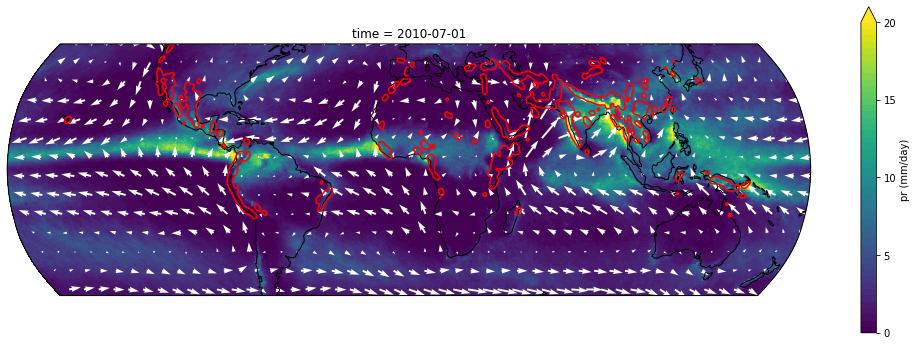

In [374]:
m=20.
plt.figure(figsize=(18,6));ax = plt.axes(projection=ccrs.Robinson());ax.coastlines()
pr_trmm_mean07.plot(ax=ax,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,m+1,m/4)},levels=np.linspace(0.,m,50))
kw = {'levels':[0.5], 'colors':['r']}
upslope_qw_thresh_era5_07_s.sel(latitude=slice(50.,-50.)).plot.contour(ax=ax,transform=ccrs.PlateCarree(),**kw)

u=u100m_era5_mean07.sel(latitude=slice(50., -50.,30),longitude=slice(0., 360.,30))
v=v100m_era5_mean07.sel(latitude=slice(50., -50.,30),longitude=slice(0., 360.,30))

X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
ax.quiver(np.array(Y),np.array(X), np.array(u), np.array(v), transform=ccrs.PlateCarree(),color="w",scale=150,scale_units="height") #np.hypot(np.array(u),np.array(v)) to color the arrows according to magnitude


In [375]:
# = xr.DataArray(,.coords)
U = np.array(u100m_era5_mean07.sel(latitude=slice(40., -20.,1),longitude=slice(50., 170.,1)))
V = np.array(v100m_era5_mean07.sel(latitude=slice(40., -20.,1),longitude=slice(50., 170.,1)))
unsmoothed_xr = upslope_qw_thresh_era5_07.sel(latitude=slice(40., -20.,1),longitude=slice(50., 170.,1))
unsmoothed = np.array(unsmoothed_xr)
t=time.time()
kernel = spaceVaryingAnisotropicKernel(U,V,4)
print(time.time()-t)
rainyregion_smoothed = 1.*(convolveCustom(unsmoothed,kernel)>0.01)
print(time.time()-t)

18.672565698623657
19.882023572921753


Text(0.5, 1.0, 'Anisotropic smoothing')

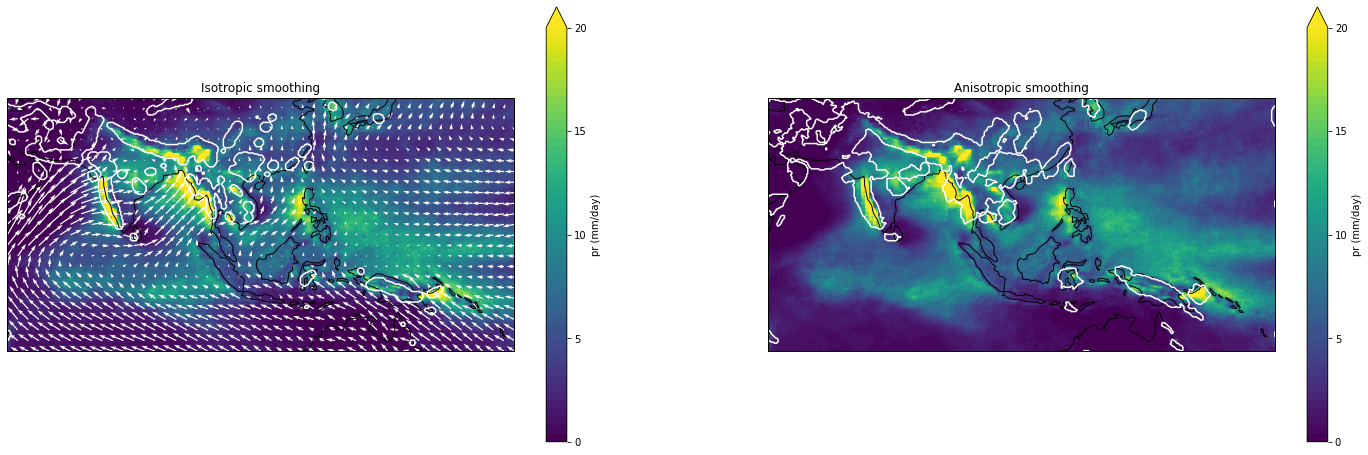

In [376]:
rainyregion_smoothed = xr.DataArray(rainyregion_smoothed,unsmoothed_xr.coords)

kw = {'levels':[0.5], 'colors':['w']}

m=20.
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(25,8),subplot_kw={'projection': ccrs.PlateCarree()})
pr_trmm_mean07.sel(latitude=slice( -20.,40.),longitude=slice(50., 170.)).plot(ax=ax1,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,m+1,m/4)},levels=np.linspace(0.,m,50))
upslope_qw_thresh_era5_07_s.sel(latitude=slice(40.,-20.),longitude=slice(50., 170.)).plot.contour(ax=ax1,transform=ccrs.PlateCarree(),**kw)

u=u100m_era5_mean07.sel(latitude=slice(40., -20.,10),longitude=slice(50., 170.,10))
v=v100m_era5_mean07.sel(latitude=slice(40., -20.,10),longitude=slice(50., 170.,10))

X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
ax1.quiver(np.array(Y),np.array(X), np.array(u), np.array(v), transform=ccrs.PlateCarree(),color="w")#,scale=150,scale_units="height")



pr_trmm_mean07.sel(latitude=slice( -20.,40.),longitude=slice(50., 170.)).plot(ax=ax2,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,m+1,m/4)},levels=np.linspace(0.,m,50))
rainyregion_smoothed.plot.contour(ax=ax2,transform=ccrs.PlateCarree(),**kw)

ax1.coastlines();ax2.coastlines()
ax1.set_title("Isotropic smoothing");ax2.set_title("Anisotropic smoothing")

In [378]:
def objfunction_iso_smoothing(thresh,pr,upslope_w,dx):
    mask=1.*(xr.apply_ufunc(gaussian_filter,1.*(upslope_w>thresh),kwargs={"sigma":0.5/dx})>0.1)
    sms = spatial_mean(mask)
    a = precip_pct(mask,pr)/100
    return 100*np.array(a/sms-1), 100*sms

def objfunction_aniso_smoothing(thresh,pr,upslope_w,dx,U,V):

    unsmoothed_xr=1.*(upslope_w>thresh)
    unsmoothed = np.array(unsmoothed_xr)
    t=time.time()
    kernel = spaceVaryingAnisotropicKernel(U,V,4)
    print(time.time()-t)
    rainyregion_smoothed = 1.*(convolveCustom(unsmoothed,kernel)>0.01)
    print(time.time()-t)
    
    mask=xr.DataArray(rainyregion_smoothed,unsmoothed_xr.coords)
    
    sms = spatial_mean(mask)
    a = precip_pct(mask,pr)/100
    return 100*np.array(a/sms-1), 100*sms
    
def plotpct(objfunction,lbl,args,ts = np.linspace(0.,0.4,8)):#pr,upslope_w,dx,lbl,objfunction):
    x = np.array([objfunction(*tuple([t]+list(args))) for t in ts])
    pcts = x[:,0]
    smlss = x[:,1]

    plt.plot(smlss,pcts,label=lbl)
    plt.xscale('log')
    plt.xlim(100,min(smlss))

    plt.legend()


168.37778735160828
180.20191383361816
169.57036185264587
180.9627125263214
168.92066383361816
181.46342849731445
171.0328562259674
183.0103259086609
171.831472158432
184.00955295562744
169.89615726470947
182.1347999572754
171.9681670665741
184.55850481987
167.71096229553223
180.25384616851807


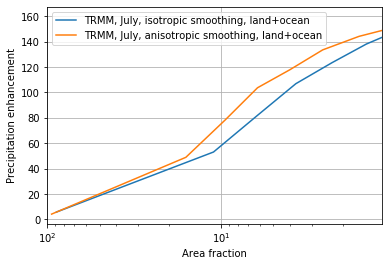

In [379]:
plotpct(objfunction_iso_smoothing,"TRMM, July, isotropic smoothing, land+ocean",[pr_trmm_mean07,upslope_qws_era5_07,dx5])

U = np.array(u100m_era5_mean07)
V = np.array(v100m_era5_mean07)   
plotpct(objfunction_aniso_smoothing,"TRMM, July, anisotropic smoothing, land+ocean",[pr_trmm_mean07,upslope_qws_era5_07,dx5,U,V])

plt.xlabel("Area fraction")
plt.ylabel("Precipitation enhancement")
plt.grid()

168.71273136138916
182.83021569252014
168.94792890548706
181.97608995437622
167.34723711013794
179.24955558776855
160.9792776107788
172.30314540863037
161.52148509025574
172.8334584236145


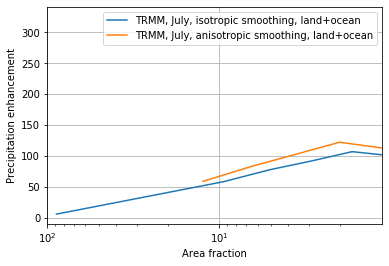

In [336]:
plotpct(objfunction_iso_smoothing,"TRMM, July, isotropic smoothing, land+ocean",[pr_trmm_mean07,upslope_qws_era5_07,dx5])

U = np.array(u100m_era5_mean07)
V = np.array(v100m_era5_mean07)   
plotpct(objfunction_aniso_smoothing,"TRMM, July, anisotropic smoothing, land+ocean",[pr_trmm_mean07,upslope_qws_era5_07,dx5,U,V],np.linspace(0.05,0.3,5))

plt.xlabel("Area fraction")
plt.ylabel("Precipitation enhancement")
plt.grid()

In [380]:
upslope_qw_thresh_era5_07=1.*(upslope_qws_era5_07>0.2)#
upslope_qw_thresh_era5_07_s=1.*(xr.apply_ufunc(gaussian_filter,
                                               upslope_qw_thresh_era5_07,
                                               kwargs={"sigma":0.5/dx5})>0.1)

# compute anisotropic global mask
U = np.array(u100m_era5_mean07)
V = np.array(v100m_era5_mean07)
unsmoothed_xr = upslope_qw_thresh_era5_07
unsmoothed = np.array(unsmoothed_xr)
t=time.time()
kernel = spaceVaryingAnisotropicKernel(U,V,4)
print(time.time()-t)
rainyregion_smoothed = 1.*(convolveCustom(unsmoothed,kernel)>0.01)
print(time.time()-t)

173.37279987335205
184.41731691360474


In [381]:
upslope_qw_thresh_era5_07=1.*(upslope_qws_era5_07>0.2)#
upslope_qw_thresh_era5_07_s=1.*(xr.apply_ufunc(gaussian_filter,
                                               upslope_qw_thresh_era5_07,
                                               kwargs={"sigma":0.5/dx5})>0.1)

Text(0.5, 1.0, 'Anisotropic smoothing, Area fraction : 5.1%, precip enhancement : 111.0%')

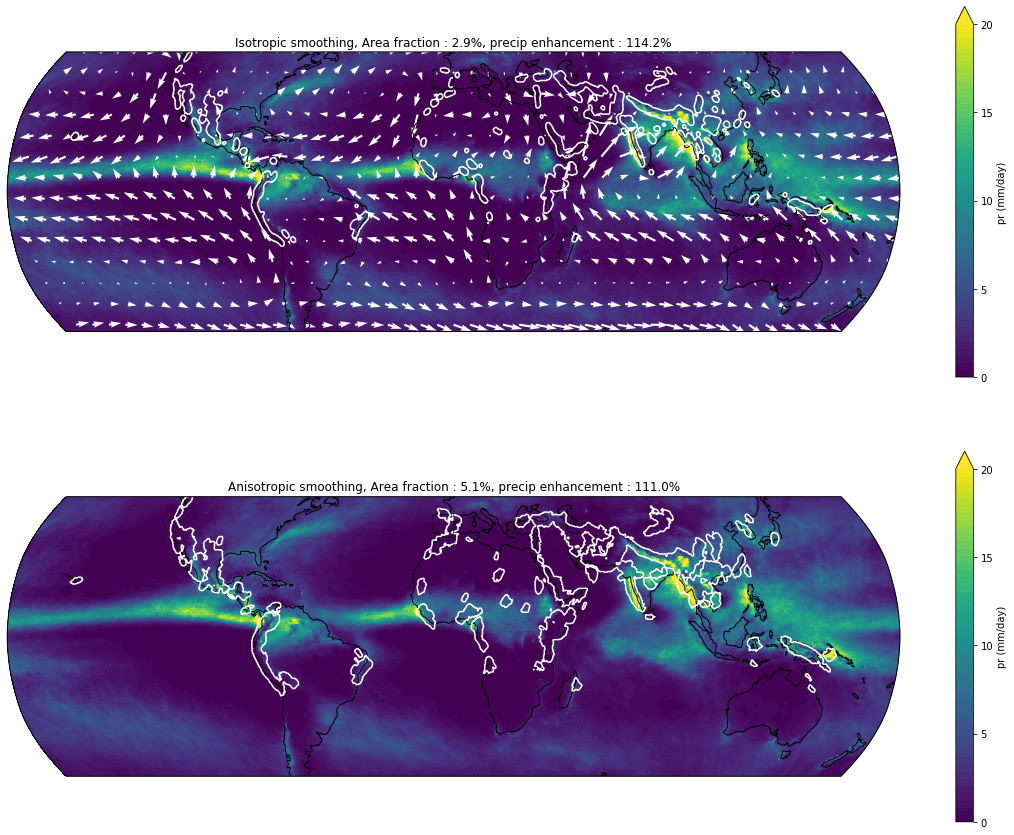

In [382]:
rainyregion_smoothed = xr.DataArray(rainyregion_smoothed,unsmoothed_xr.coords)

kw = {'levels':[0.5], 'colors':['w']}

m=20.
fig, (ax1,ax2) = plt.subplots(2,1,figsize=(20,15),subplot_kw={'projection': ccrs.Robinson()})
pr_trmm_mean07.plot(ax=ax1,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,m+1,m/4)},levels=np.linspace(0.,m,50))
upslope_qw_thresh_era5_07_s.sel(latitude=slice(50., -50.)).plot.contour(ax=ax1,transform=ccrs.PlateCarree(),**kw)

u=u100m_era5_mean07.sel(latitude=slice(50., -50.,30),longitude=slice(0., 360.,30))
v=v100m_era5_mean07.sel(latitude=slice(50., -50.,30),longitude=slice(0., 360.,30))

X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
ax1.quiver(np.array(Y),np.array(X), np.array(u), np.array(v), transform=ccrs.PlateCarree(),color="w",scale=150,scale_units="height")

pr_trmm_mean07.plot(ax=ax2,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,m+1,m/4)},levels=np.linspace(0.,m,50))
rainyregion_smoothed.sel(latitude=slice(50., -50.)).plot.contour(ax=ax2,transform=ccrs.PlateCarree(),**kw)

ax1.coastlines();ax2.coastlines()
ax1.set_title("Isotropic smoothing, Area fraction : %.1f%%, precip enhancement : %.1f%%"%(100*spatial_mean(upslope_qw_thresh_era5_07_s),100*np.array(precip_pct(upslope_qw_thresh_era5_07_s,pr_trmm_mean07)/spatial_mean(upslope_qw_thresh_era5_07_s)/100-1)))
ax2.set_title("Anisotropic smoothing, Area fraction : %.1f%%, precip enhancement : %.1f%%"%(100*spatial_mean(rainyregion_smoothed),100*np.array(precip_pct(rainyregion_smoothed,pr_trmm_mean07)/spatial_mean(rainyregion_smoothed)/100-1)))



Text(0.5, 1.0, 'Isotropic smoothing, Area fraction : 4.9%, precip enhancement : 92.7%')

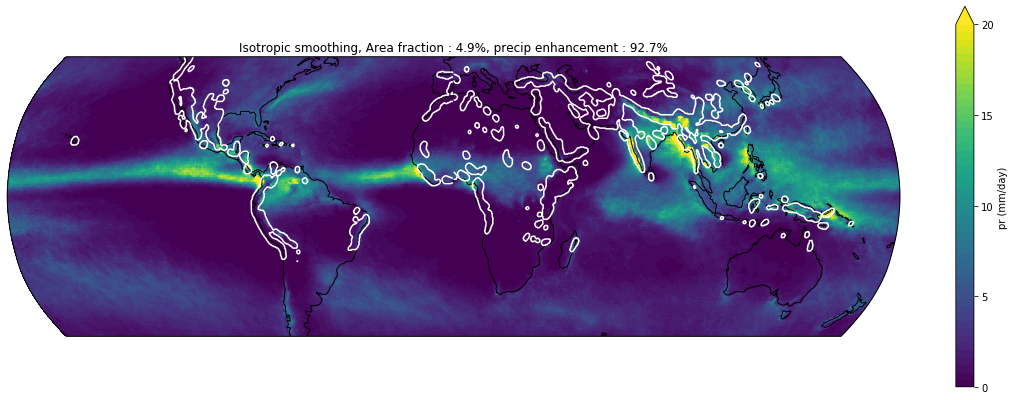

In [383]:
upslope_qw_thresh_era5_07=1.*(upslope_qws_era5_07>0.14)#
upslope_qw_thresh_era5_07_s=1.*(xr.apply_ufunc(gaussian_filter,
                                               upslope_qw_thresh_era5_07,
                                               kwargs={"sigma":0.5/dx5})>0.1)

m=20.
fig, (ax1) = plt.subplots(1,1,figsize=(20,7),subplot_kw={'projection': ccrs.Robinson()})
pr_trmm_mean07.plot(ax=ax1,transform=ccrs.PlateCarree(),cbar_kwargs={"label":"pr (mm/day)","ticks":np.arange(0.,m+1,m/4)},levels=np.linspace(0.,m,50))
upslope_qw_thresh_era5_07_s.sel(latitude=slice(50., -50.)).plot.contour(ax=ax1,transform=ccrs.PlateCarree(),**kw)

ax1.coastlines()
ax1.set_title("Isotropic smoothing, Area fraction : %.1f%%, precip enhancement : %.1f%%"%(100*spatial_mean(upslope_qw_thresh_era5_07_s),100*np.array(precip_pct(upslope_qw_thresh_era5_07_s,pr_trmm_mean07)/spatial_mean(upslope_qw_thresh_era5_07_s)/100-1)))


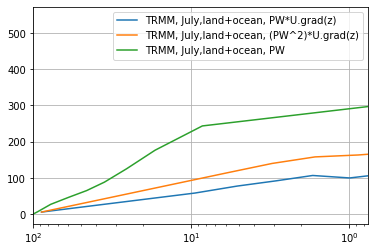

In [372]:
plotpct(objfunction_iso_smoothing,"TRMM, July,land+ocean, PW*U.grad(z)",[pr_trmm_mean07,upslope_qws_era5_07,dx5])

n=1
upslope_qqqw_era5_07 = 20*(pw_era5_mean07.interp_like(upslope_w_era5_07)/30)**(n+1)*upslope_w_era5_07
upslope_qqqws_era5_07 = xr.apply_ufunc(gaussian_filter,upslope_qqqw_era5_07,kwargs={"sigma":.5/dx5})
plotpct(objfunction_iso_smoothing,"TRMM, July,land+ocean, (PW^%i)*U.grad(z)"%(n+1),[pr_trmm_mean07,upslope_qqqws_era5_07,dx5],np.linspace(0,0.5,10))

plotpct(objfunction_iso_smoothing,"TRMM, July,land+ocean, PW",[pr_trmm_mean07,pw_era5_mean07.interp_like(upslope_w_era5_07),dx5],np.linspace(0,55.,10))


plt.grid()
